In [68]:
import pandas as pd
from warnings import simplefilter; simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

import sys
sys.path.append("../boa-learn")

from src.load import load_nhanes

In [70]:
year=2010
df = load_nhanes(year)
df.to_csv(str(year)+'.csv')

In [58]:
df=pd.read_csv('2010.csv',index_col=0)

<Axes: xlabel='timeline'>

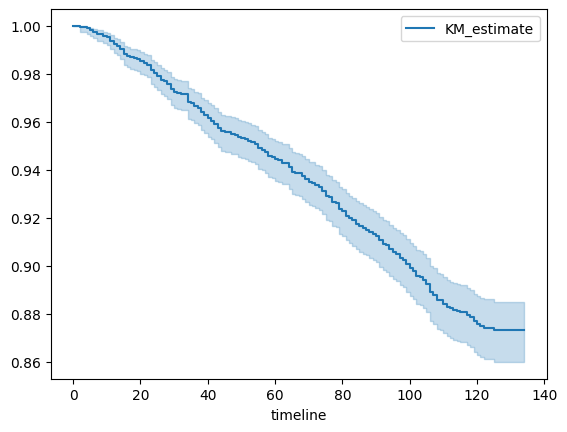

In [60]:
T=df.months_until_death
E=df.is_dead
kmf = KaplanMeierFitter()
kmf.fit(T, E)  
kmf.plot()

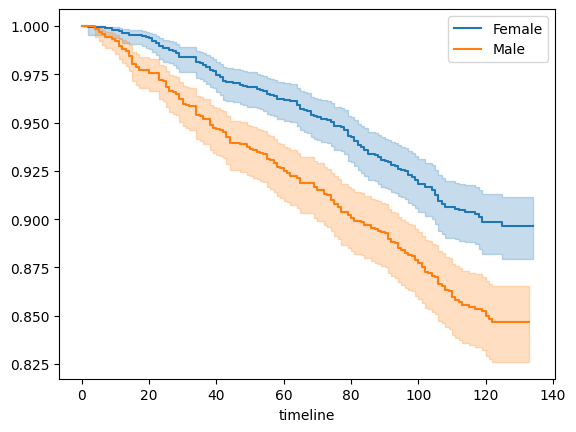

In [61]:
ax=plt.subplot()
groups = df['sex']
ix = (groups == 2)
kmf.fit(T[ix], E[ix], label='Female')
ax = kmf.plot_survival_function(ax=ax)
kmf.fit(T[~ix], E[~ix], label='Male')
ax = kmf.plot_survival_function()

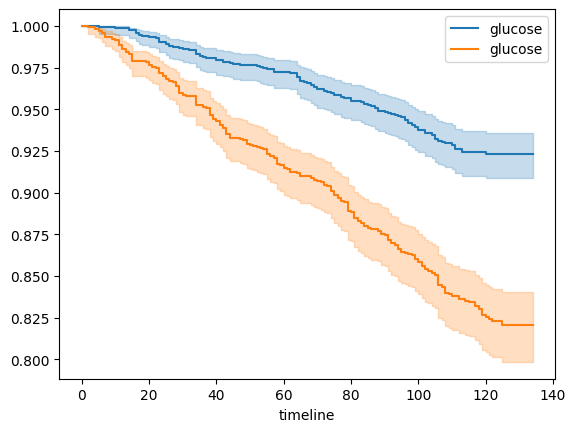

In [62]:
ax=plt.subplot()
groups = df['glucose']
ix = (groups < 5.5)
kmf.fit(T[ix], E[ix], label='glucose')
ax = kmf.plot_survival_function(ax=ax)
kmf.fit(T[~ix], E[~ix], label='glucose')
ax = kmf.plot_survival_function()

In [72]:
year=2012
df = load_nhanes(year)
df.to_csv(str(year)+'.csv')

In [74]:
df=pd.read_csv('2012.csv',index_col=0)
X_train=df[['age','sex','glucose']+cbc_sub]
y_train=df['is_dead']

In [75]:
logreg= LogisticRegression(max_iter=1000)
logreg.fit(X_train,y_train)

LogisticRegression(max_iter=1000)

In [78]:
df=pd.read_csv('2010.csv',index_col=0)
X_test=df[['age','sex','glucose']+cbc_sub]
y_test=df['is_dead']

In [79]:
y_pred=logreg.predict(X_test)
y_pred_proba= logreg.predict_proba(X_test) [::,1]

In [80]:
false_positive_rate, true_positive_rate, _ = metrics.roc_curve(y_test, y_pred_proba)
auc= metrics.roc_auc_score(y_test, y_pred_proba)

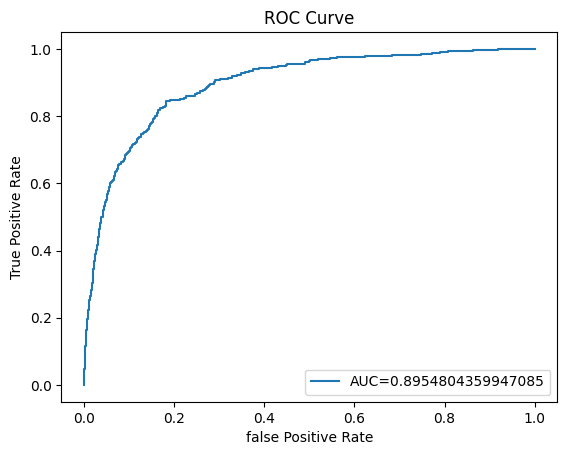

In [81]:
plt.plot(false_positive_rate, true_positive_rate,label="AUC="+str(auc))
plt.title('ROC Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('false Positive Rate')
plt.legend(loc=4)

In [82]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.91      0.98      0.94      2555
         1.0       0.71      0.27      0.39       358

    accuracy                           0.90      2913
   macro avg       0.81      0.63      0.67      2913
weighted avg       0.88      0.90      0.88      2913



In [88]:
df['biologically_older']=y_pred

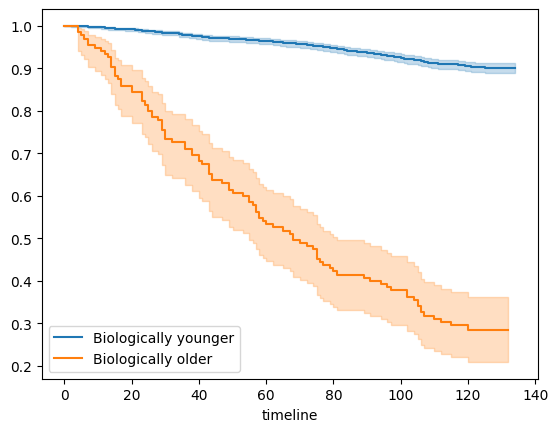

In [89]:
ax=plt.subplot()
groups = df['biologically_older']
ix = (groups == 0)
kmf.fit(T[ix], E[ix], label='Biologically younger')
ax = kmf.plot_survival_function(ax=ax)
kmf.fit(T[~ix], E[~ix], label='Biologically older')
ax = kmf.plot_survival_function()

In [86]:
year=2010
df.to_csv(str(year)+'.csv')